In [8]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import math


In [5]:
# print working directory
import os
print(os.getcwd())

/home/zister/Documents/University/SoSe24/ADL4CV/diffusion/adl4cv-3d-diffusion


In [6]:
# plane
#pc = np.load('../data/ShapeNetCore.v2.PC15k/02691156/train/1a04e3eab45ca15dd86060f189eb133.npy')

# chair
#pc = np.load('data/ShapeNetCore.v2.PC15k/03001627/train/1a6f615e8b1b5ae4dbbc9440457e303e.npy')

# car
pc = np.load('data/ShapeNetCore.v2.PC15k/02958343/train/1a1dcd236a1e6133860800e6696b8284.npy')

#visualize_point_cloud(pc)

/home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'multidict'

Falling back to a static output.
  warnings.warn(


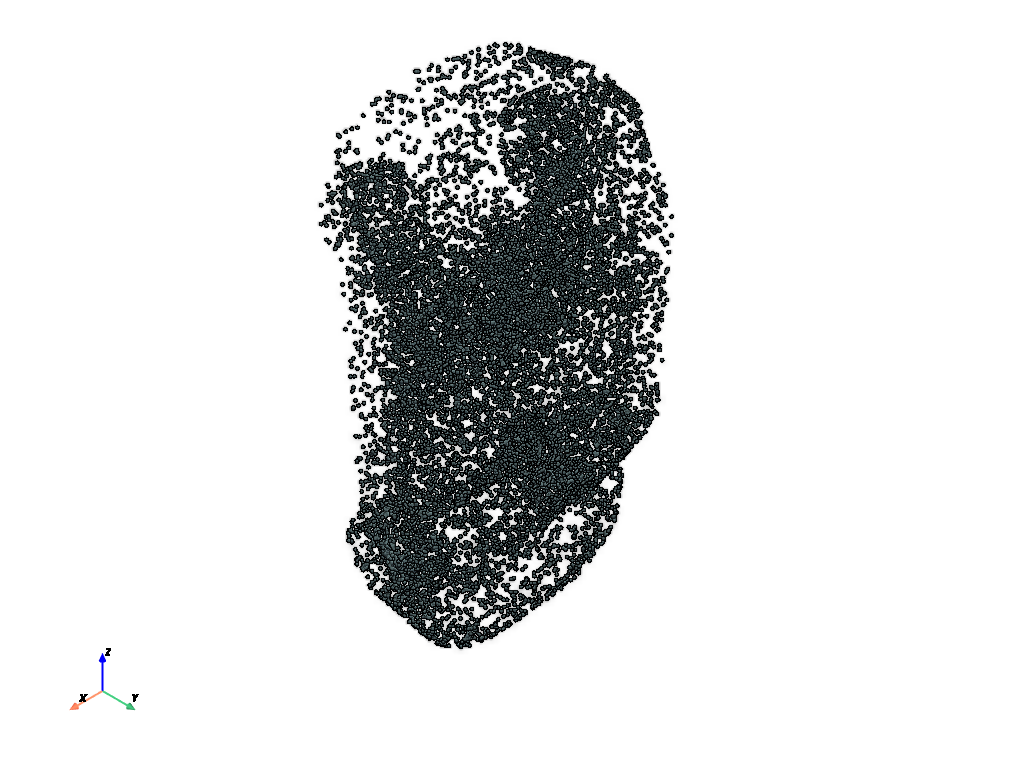

In [7]:
# visualize pc with matplotlib
def visualize_point_cloud(pc):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pc[:,0], pc[:,1], pc[:,2])
    plt.show()
    
def visualize_point_cloud_vtk(pc):
    cloud = pv.PolyData(pc)
    cloud.plot(render_points_as_spheres=True, point_size=5, eye_dome_lighting=True)

visualize_point_cloud_vtk(pc)

In [8]:
def to_spherical(coords: torch.Tensor) -> torch.Tensor:
    """
    Convert Cartesian coordinates to n-dimensional spherical coordinates.

    Args:
        coords (torch.Tensor): Tensor representing Cartesian coordinates (x_1, ... x_n).
                               Shape: (..., n)

    Returns:
        torch.Tensor: Tensor representing spherical coordinates (r, phi_1, ... phi_n-1).
                      Shape: (..., n)
    """    
    n = coords.shape[-1]
    
    # We compute the coordinates following https://en.wikipedia.org/wiki/N-sphere#Spherical_coordinates
    r = torch.norm(coords, dim=-1, keepdim=True)

    # phi_norms are the quotients in the wikipedia article above
    phi_norms = torch.norm(torch.tril(coords.flip(-1).unsqueeze(-2).expand((*coords.shape, n))), dim=-1).flip(-1)
    phi = torch.arccos(coords[..., :-2]/phi_norms[..., :-2])
    phi_final = torch.arccos(coords[..., -2:-1]/phi_norms[..., -2:-1]) + (2*math.pi - 2*torch.arccos(coords[..., -2:-1]/phi_norms[..., -2:-1]))*(coords[..., -1:] < 0)
            
    return torch.cat([r, phi, phi_final], dim=-1)

def to_cartesian(coords: torch.Tensor) -> torch.Tensor:
    """
    Convert n-dimensional spherical coordinates to Cartesian coordinates.

    Args:
        coords (torch.Tensor): Tensor representing spherical coordinates (r, phi_1, ... phi_n-1).
                               Shape: (..., n)

    Returns:
        torch.Tensor: Tensor representing Cartesian coordinates (x_1, ... x_n).
                      Shape: (..., n)
    """    
    n = coords.shape[-1]    
    r, phi = coords[..., 0:1], coords[..., 1:]
    
    phi_lower = torch.sin(torch.tril(phi.unsqueeze(-2).expand((*phi.shape, n-1))))
    phi_sin_prod = torch.prod(phi_lower + torch.triu(torch.ones((*phi.shape, n-1), device=coords.device), diagonal=1), dim=-1)
    
    x_1 = r * torch.cos(phi[..., 0:1])
    x_mid = r * torch.cos(phi[..., 1:]) * phi_sin_prod[..., :-1]
    x_n = r * phi_sin_prod[..., -1:]
    
    return torch.cat([x_1, x_mid, x_n], dim=-1)

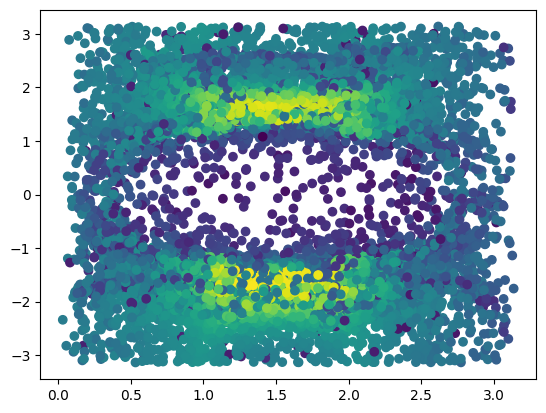

In [9]:
data = pc
# resize to grid of 512, 1024
data = torch.tensor(data)
sph_data = to_spherical(data)

#sph_data[:, 1:] = (sph_data[:, 1:] / np.pi) * 512
sph_data[:, 2] = sph_data[:, 2] - np.pi
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='mollweide')
ax.scatter(sph_data[:, 1], sph_data[:, 2], c=sph_data[:, 0], cmap='viridis')


(524288, 3)


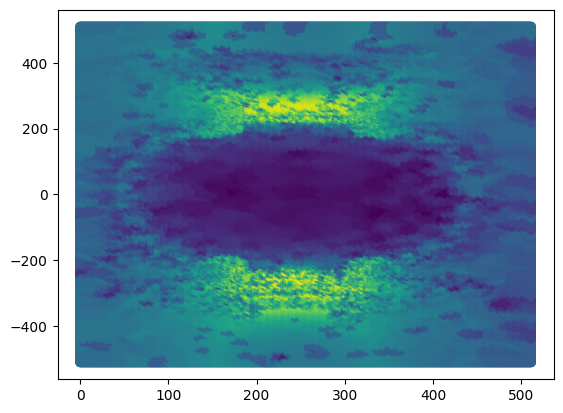

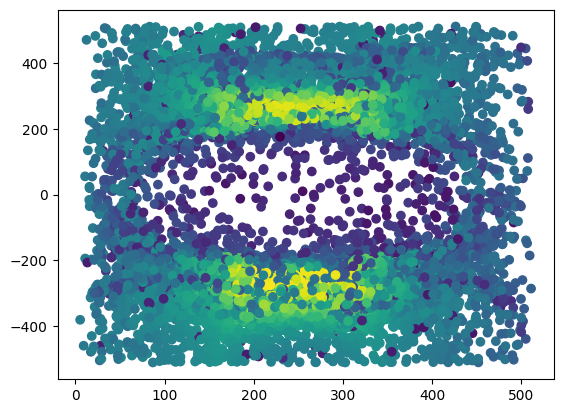

In [11]:
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
from pointnet2_ops import pointnet2_utils

# create a grid of 512x1024
grid_x, grid_y = np.mgrid[0:512, -512:512]
scaled_data = sph_data.clone()
scaled_data[:, 1:] = (scaled_data[:, 1:] / np.pi) * 512

tree = cKDTree(scaled_data[:, 1:])
dist, ind = tree.query(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), k=3)
print(ind.shape)
# interpolate the data
inter_data = sph_data[:, 0][ind].mean(axis=1)
plt.scatter(grid_x, grid_y, c=inter_data, cmap='viridis')
plt.show()


plt.scatter(scaled_data[:, 1], scaled_data[:, 2], c=scaled_data[:, 0], cmap='viridis')

In [9]:
import pytorch_fre.pytorch_fre_utils as fre
import torch

/home/zister/Documents/University/SoSe24/ADL4CV/diffusion/adl4cv-3d-diffusion/pytorch_fre/pytorch_fre_utils.py:15: UserWarning: Unable to load pytorch_fre cpp extension. JIT Compiling.
  warnings.warn("Unable to load pytorch_fre cpp extension. JIT Compiling.")


In [14]:
# transform to tensor
grid_x = grid_x/512
grid_x *= np.pi

grid_y = grid_y/512
grid_y *= np.pi

grid = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)
grid = torch.tensor(grid, dtype=torch.float32)
print(grid.shape)
grid_cuda = torch.tensor(np.stack([grid_x.ravel(), grid_y.ravel()], axis=1), dtype=torch.float32).cuda().unsqueeze(0)

torch.Size([524288, 2])


In [15]:
data_cuda = scaled_data[:, 1:].cuda().unsqueeze(0)
sph_data_cuda = scaled_data.cuda().unsqueeze(0)/512
sph_data_cuda[:, 1:] = sph_data_cuda[:, 1:] * np.pi

In [16]:
dist, ind = fre.three_nn(grid_cuda, data_cuda)
torch.cuda.synchronize()
# ind to long
print(ind)
# interpolate the data
features_cuda = sph_data_cuda[:, :, 0].unsqueeze(0).contiguous()
print(features_cuda.shape)
weights = dist/dist.sum(dim=2, keepdim=True)
inter_data = fre.three_interpolate(features_cuda, ind, weights)

tensor([[[ 1354,  9767, 11754],
         [ 1354,  9767, 11754],
         [ 1354,  9767, 11754],
         ...,
         [ 7312,  4865,   811],
         [ 7312,  4865,   811],
         [ 7312,  4865,   811]]], device='cuda:0', dtype=torch.int32)
torch.Size([1, 1, 15000])


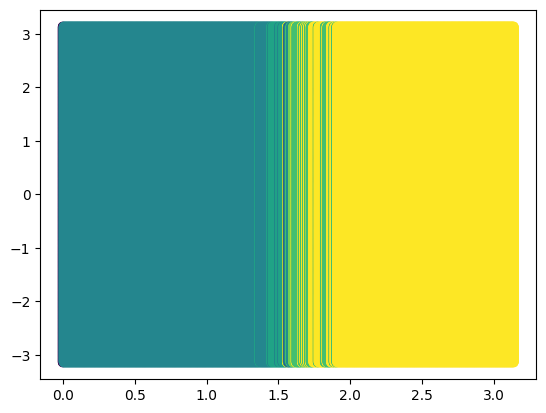

In [17]:
plt.scatter(grid_x, grid_y, c=inter_data.cpu(), cmap='viridis')
plt.show()

torch.Size([1, 1024, 512])


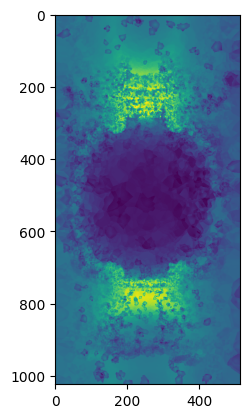

In [13]:
import torch_harmonics as th
torch.pi = math.pi

nlat = 512
nlon = 1024
batch_size = 1

sht = th.RealSHT(nlat, nlon, grid='equiangular', lmax=50, mmax=50).cuda()

reshaped_data = inter_data.reshape(batch_size, nlat, nlon).permute(0, 2, 1)
print(reshaped_data.shape)
plt.imshow(reshaped_data.cpu().numpy()[0])

coeffs = sht.forward(inter_data.reshape(batch_size, nlat, nlon))

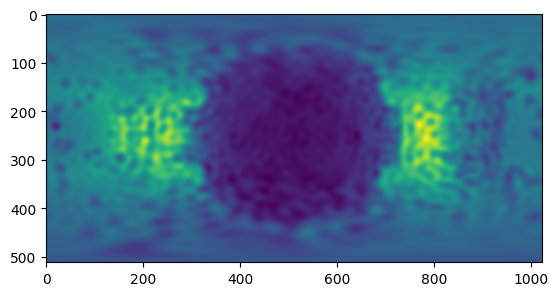

In [14]:
coeffs.shape
#plt.imshow(coeffs.cpu().real[0])
isth = th.InverseRealSHT(nlat, nlon, grid='equiangular', lmax=50, mmax=50).cuda()
reconstructed = isth.forward(coeffs)
plt.imshow(reconstructed.cpu().numpy()[0])


In [1]:
import numpy as np
import torch
from pytorch_fre import pytorch_fre_modules as fre_modules
import math
torch.pi = math.pi
%load_ext autoreload
%autoreload 2

#loss = fre_modules.FreLoss(512, 1024, lmax=50, mmax=50)
loss = fre_modules.FreLoss(256, 512, lmax=50, mmax=50)

from data_loader.data_loaders import ShapeNetAugmentedDataLoader
loader = ShapeNetAugmentedDataLoader('data', 1, shuffle=False, size=32)

loader_iter = iter(loader)
_, data1 = next(loader_iter)
_, data2 = next(loader_iter)

data1 = data1.cuda()
data2 = data2.cuda()
ls = loss.forward(data1, data2)
print(ls)

/home/zister/Documents/University/SoSe24/ADL4CV/diffusion/adl4cv-3d-diffusion/pytorch_fre/pytorch_fre_utils.py:15: UserWarning: Unable to load pytorch_fre cpp extension. JIT Compiling.
  warnings.warn("Unable to load pytorch_fre cpp extension. JIT Compiling.")


RuntimeError: Error building extension '_ext': [1/4] /opt/cuda/bin/nvcc  -ccbin /home/zister/miniconda3/envs/3d_diff_2.0/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -I/home/zister/Documents/University/SoSe24/ADL4CV/diffusion/adl4cv-3d-diffusion/pytorch_fre/_ext-src/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/TH -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/THC -isystem /opt/cuda/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/include/python3.8 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_37,code=compute_37 -gencode=arch=compute_37,code=sm_37 -gencode=arch=compute_50,code=sm_50 -gencode=arch=compute_60,code=sm_60 -gencode=arch=compute_61,code=sm_61 -gencode=arch=compute_62,code=sm_62 -gencode=arch=compute_70,code=sm_70 -gencode=arch=compute_75,code=sm_75 --compiler-options '-fPIC' -O3 -Xfatbin -compress-all -allow-unsupported-compiler -std=c++14 -c /home/zister/Documents/University/SoSe24/ADL4CV/diffusion/adl4cv-3d-diffusion/pytorch_fre/_ext-src/src/interpolate_gpu.cu -o interpolate_gpu.cuda.o 
[31mFAILED: [0minterpolate_gpu.cuda.o 
/opt/cuda/bin/nvcc  -ccbin /home/zister/miniconda3/envs/3d_diff_2.0/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -I/home/zister/Documents/University/SoSe24/ADL4CV/diffusion/adl4cv-3d-diffusion/pytorch_fre/_ext-src/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/TH -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/THC -isystem /opt/cuda/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/include/python3.8 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_37,code=compute_37 -gencode=arch=compute_37,code=sm_37 -gencode=arch=compute_50,code=sm_50 -gencode=arch=compute_60,code=sm_60 -gencode=arch=compute_61,code=sm_61 -gencode=arch=compute_62,code=sm_62 -gencode=arch=compute_70,code=sm_70 -gencode=arch=compute_75,code=sm_75 --compiler-options '-fPIC' -O3 -Xfatbin -compress-all -allow-unsupported-compiler -std=c++14 -c /home/zister/Documents/University/SoSe24/ADL4CV/diffusion/adl4cv-3d-diffusion/pytorch_fre/_ext-src/src/interpolate_gpu.cu -o interpolate_gpu.cuda.o 
nvcc warning : incompatible redefinition for option 'compiler-bindir', the last value of this option was used
nvcc fatal   : Unsupported gpu architecture 'compute_37'
[2/4] /home/zister/miniconda3/envs/3d_diff_2.0/bin/x86_64-conda-linux-gnu-c++ -MMD -MF interpolate.o.d -DTORCH_EXTENSION_NAME=_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -I/home/zister/Documents/University/SoSe24/ADL4CV/diffusion/adl4cv-3d-diffusion/pytorch_fre/_ext-src/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/TH -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/THC -isystem /opt/cuda/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/include/python3.8 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++14 -O3 -c /home/zister/Documents/University/SoSe24/ADL4CV/diffusion/adl4cv-3d-diffusion/pytorch_fre/_ext-src/src/interpolate.cpp -o interpolate.o 
[3/4] /home/zister/miniconda3/envs/3d_diff_2.0/bin/x86_64-conda-linux-gnu-c++ -MMD -MF bindings.o.d -DTORCH_EXTENSION_NAME=_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -I/home/zister/Documents/University/SoSe24/ADL4CV/diffusion/adl4cv-3d-diffusion/pytorch_fre/_ext-src/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/TH -isystem /home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/torch/include/THC -isystem /opt/cuda/include -isystem /home/zister/miniconda3/envs/3d_diff_2.0/include/python3.8 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++14 -O3 -c /home/zister/Documents/University/SoSe24/ADL4CV/diffusion/adl4cv-3d-diffusion/pytorch_fre/_ext-src/src/bindings.cpp -o bindings.o 
ninja: build stopped: subcommand failed.


0.1238

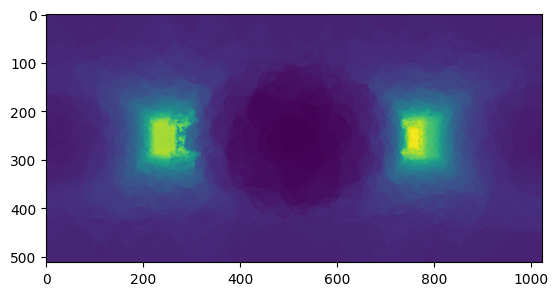

tensor([[[1.6015e-01, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [5.7646e-05, 1.2424e-03, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.3791e-02, 1.6515e-06, 2.0507e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.0176e-06, 5.2143e-07, 1.7201e-08,  ..., 1.4736e-06,
          0.0000e+00, 0.0000e+00],
         [5.8344e-08, 1.0982e-07, 1.5471e-08,  ..., 1.1212e-08,
          1.1258e-06, 0.0000e+00],
         [1.2710e-06, 1.8749e-07, 1.8705e-07,  ..., 9.1976e-07,
          6.3476e-08, 8.9911e-07]],

        [[2.7470e-04, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.2152e-09, 2.7546e-04, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [3.4268e-03, 4.0931e-05, 1.0720e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.7347e-07, 9.6574e-07, 3.5588e-07,  ..., 5.8443e-06,
          0.000

In [62]:
ls

0.4448580662229411

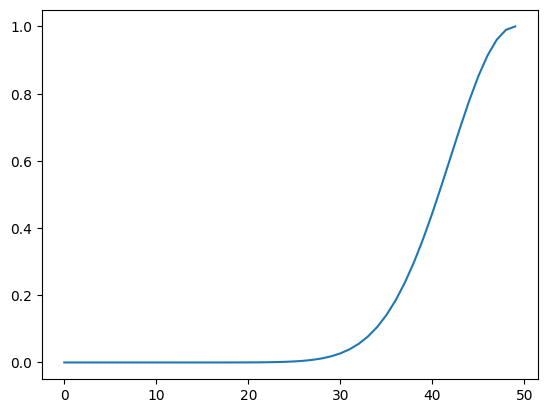

In [10]:
l = np.arange(1, 51)
s2_fre = 50#**2
r = np.exp(-((50-l)**2)/(2*s2_fre))
plt.plot(r)
r[40]

torch.Size([16, 50, 50])


/tmp/ipykernel_596723/3024441728.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(coeff.cpu()))


torch.Size([16])

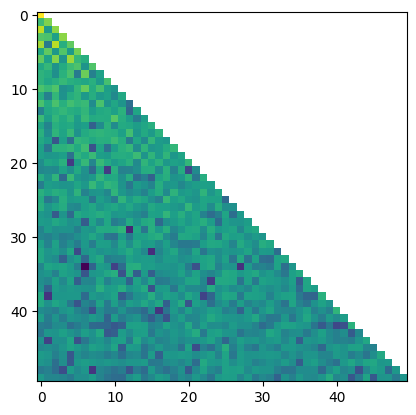

In [67]:
coeffs = ls
print(test.shape)
scaled = coeffs.cpu() * r.reshape(1, 50, 1)
plt.imshow(np.log(coeff.cpu()))
tot = torch.sum(scaled, dim=(1, 2))
tot.shape

/home/zister/miniconda3/envs/3d_diff_2.0/lib/python3.8/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Total number of data:2458
Min number of points: (train)4096 (test)4096
RADIUS:: [3.0591438 2.7624054 2.928901  2.8483639]


In [4]:
l = loss.forward(data1, data2)
l

TypeError: 'torch.Size' object is not callable

In [4]:
import torch
import torch_harmonics as th
import math
torch.pi = math.pi

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nlat = 512
nlon = 2*nlat
batch_size = 32
signal = torch.randn(batch_size, nlat*nlon).to(device)

# transform data on an equiangular grid
sht = th.RealSHT(nlat, nlon, grid="equiangular").to(device)

coeffs = sht.forward(signal.reshape(batch_size, nlat, nlon))

In [54]:
l

tensor(0., device='cuda:0')

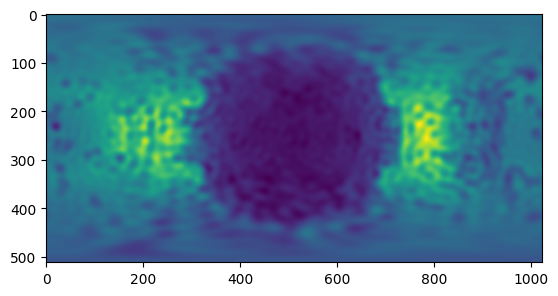

In [47]:
isht = th.InverseRealSHT(512, 1024, grid='equiangular', lmax=50, mmax=50).cuda()
recon = isht.forward(l)
plt.imshow(recon.cpu().numpy()[0])

In [20]:
np.stack([grid_x.ravel(), grid_y.ravel()], axis=1).shape
# add a third dimension to the grid with the radius being 1
grid = np.stack([np.ones(grid_x.size), grid_x.ravel(), grid_y.ravel()], axis=1)
cart = to_cartesian(torch.tensor(grid))
dist, ind = pointnet2_utils.three_nn(data.unsqueeze(0), cart.unsqueeze(0))
inter_data = data[ind[0, 1]]


tensor([[ 1.0000, -0.0000, -0.0000],
        [ 1.0000, -0.0000, -0.0000],
        [ 1.0000,  0.0000, -0.0000],
        ...,
        [-0.4717,  0.8801,  0.0546],
        [-0.4717,  0.4295,  0.7701],
        [-0.4717, -0.4159,  0.7775]], dtype=torch.float64)

In [13]:
x = np.array([[0, 1, 0], [0, 1, 1]])
y = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

y_prime = y[:, 2, np.newaxis]
print(x[:, 2], y_prime)
x[:, 2]-y_prime

[0 1] [[3]
 [6]
 [9]]


array([[-3, -2],
       [-6, -5],
       [-9, -8]])

In [14]:
def spherical_distance(p1, p2):
    sin_p1_theta = np.sin(p1[:, 1])
    sin_p2_theta = np.sin(p2[:, 1])
    cos_p1_theta = np.cos(p1[:, 1])
    cos_p2_theta = np.cos(p2[:, 1])
    cos_p1_phi_minus_p2_phi = np.cos(p1[:, 2] - p2[:, 2, np.newaxis])
    
    print(sin_p1_theta.shape, sin_p2_theta.shape, cos_p1_theta.shape, cos_p2_theta.shape, cos_p1_phi_minus_p2_phi.shape)
    out = sin_p1_theta[:, np.newaxis] * sin_p2_theta
    print(out.shape)
    print(cos_p1_phi_minus_p2_phi.shape)
    out *= cos_p1_phi_minus_p2_phi
    out += cos_p1_theta * cos_p2_theta

k = 10
sd_knn = 0.1

p1 = np.array([[0, 1, 0], [0, 1, 1]])
dist = spherical_distance(p1, spherical_pc)
ind = np.argpartition(dist, k)[:k]
dist = dist[ind]
points = pc[ind]

w_prime = np.exp(-dist**2 / 0.1)
w = w_prime / np.sum(w_prime)

print(np.sum(w*points[:, 0]))

p1[0] = np.sum(w * points[:, 0])

p1[0]

(2,) (15000,) (2,) (15000,) (15000, 2)
(2, 15000)
(15000, 2)


ValueError: operands could not be broadcast together with shapes (2,15000) (15000,2) (2,15000) 

In [15]:
visualize_point_cloud(pc)

In [23]:
norm_pc = normalize_point_cloud(pc)

In [25]:
from sklearn.neighbors import BallTree
tree = BallTree(norm_pc, metric='haversine')

In [10]:
import matplotlib.pyplot as plt
import re
import math

log_data = """
2024-06-26 15:01:32,072 - trainer - INFO -     emd_loss       : 5.988357399740527
2024-06-26 15:01:32,072 - trainer - INFO -     pu_emd_loss    : 5.1641051971143295
2024-06-26 15:02:25,753 - trainer - INFO -     emd_loss       : 1.37111275042257
2024-06-26 15:02:25,753 - trainer - INFO -     pu_emd_loss    : 0.7187555086228156
2024-06-26 15:03:19,500 - trainer - INFO -     emd_loss       : 1.2547869143947479
2024-06-26 15:03:19,500 - trainer - INFO -     pu_emd_loss    : 0.6234736110894911
2024-06-26 15:04:13,060 - trainer - INFO -     emd_loss       : 1.1483155258240239
2024-06-26 15:04:13,060 - trainer - INFO -     pu_emd_loss    : 0.5475015625838311
2024-06-26 15:05:17,071 - trainer - INFO -     emd_loss       : 1.0891981961265687
2024-06-26 15:05:17,071 - trainer - INFO -     pu_emd_loss    : 0.49835433017823005
2024-06-26 15:06:10,836 - trainer - INFO -     emd_loss       : 1.0456500187996896
2024-06-26 15:06:10,836 - trainer - INFO -     pu_emd_loss    : 0.461810540768408
2024-06-26 15:07:04,568 - trainer - INFO -     emd_loss       : 1.012947698754649
2024-06-26 15:07:04,568 - trainer - INFO -     pu_emd_loss    : 0.4373537676949655
2024-06-26 15:07:58,185 - trainer - INFO -     emd_loss       : 0.9763718728096255
2024-06-26 15:07:58,185 - trainer - INFO -     pu_emd_loss    : 0.414192890447955
2024-06-26 15:08:51,703 - trainer - INFO -     emd_loss       : 0.9518850638020423
2024-06-26 15:08:51,703 - trainer - INFO -     pu_emd_loss    : 0.3970685529132043
2024-06-26 15:09:55,683 - trainer - INFO -     emd_loss       : 0.9262781989189887
2024-06-26 15:09:55,683 - trainer - INFO -     pu_emd_loss    : 0.38096811982893175
2024-06-26 15:10:49,203 - trainer - INFO -     emd_loss       : 0.9172550093743109
2024-06-26 15:10:49,203 - trainer - INFO -     pu_emd_loss    : 0.3727659559057605
2024-06-26 15:11:42,600 - trainer - INFO -     emd_loss       : 0.8755827411528556
2024-06-26 15:11:42,600 - trainer - INFO -     pu_emd_loss    : 0.35380718160060143
2024-06-26 15:12:36,058 - trainer - INFO -     emd_loss       : 0.8674212915282096
2024-06-26 15:12:36,058 - trainer - INFO -     pu_emd_loss    : 0.3467438264239219
2024-06-26 15:13:29,552 - trainer - INFO -     emd_loss       : 0.8621178125181506
2024-06-26 15:13:29,552 - trainer - INFO -     pu_emd_loss    : 0.341836767811929
2024-06-26 15:14:33,449 - trainer - INFO -     emd_loss       : 0.8497866171021615
2024-06-26 15:14:33,449 - trainer - INFO -     pu_emd_loss    : 0.3349338471889496
2024-06-26 15:15:26,857 - trainer - INFO -     emd_loss       : 0.8165460344283811
2024-06-26 15:15:26,857 - trainer - INFO -     pu_emd_loss    : 0.3226094534320216
2024-06-26 15:16:20,219 - trainer - INFO -     emd_loss       : 0.8089130136274523
2024-06-26 15:16:20,219 - trainer - INFO -     pu_emd_loss    : 0.31843202248696356
2024-06-26 15:17:13,623 - trainer - INFO -     emd_loss       : 0.8118494989410523
2024-06-26 15:17:13,623 - trainer - INFO -     pu_emd_loss    : 0.31740466192845374
2024-06-26 15:18:07,097 - trainer - INFO -     emd_loss       : 0.8113925024386375
2024-06-26 15:18:07,097 - trainer - INFO -     pu_emd_loss    : 0.31629676059369116
2024-06-26 15:19:10,551 - trainer - INFO -     emd_loss       : 0.7596937667938971
2024-06-26 15:19:10,551 - trainer - INFO -     pu_emd_loss    : 0.2992694368285517
2024-06-26 15:20:03,322 - trainer - INFO -     emd_loss       : 0.7563129884581412
2024-06-26 15:20:03,322 - trainer - INFO -     pu_emd_loss    : 0.2944241617956469
2024-06-26 15:20:56,076 - trainer - INFO -     emd_loss       : 0.7495575018467442
2024-06-26 15:20:56,076 - trainer - INFO -     pu_emd_loss    : 0.29115965818205186
2024-06-26 15:21:48,803 - trainer - INFO -     emd_loss       : 0.7418356999274223
2024-06-26 15:21:48,803 - trainer - INFO -     pu_emd_loss    : 0.28991759328111527
2024-06-26 15:22:41,625 - trainer - INFO -     emd_loss       : 0.7405157281506446
2024-06-26 15:22:41,625 - trainer - INFO -     pu_emd_loss    : 0.2858445589100161
2024-06-26 15:23:44,619 - trainer - INFO -     emd_loss       : 0.733332053307564
2024-06-26 15:23:44,619 - trainer - INFO -     pu_emd_loss    : 0.2817845640163268
2024-06-26 15:24:37,420 - trainer - INFO -     emd_loss       : 0.7046394973031936
2024-06-26 15:24:37,420 - trainer - INFO -     pu_emd_loss    : 0.2748921448665281
2024-06-26 15:25:30,541 - trainer - INFO -     emd_loss       : 0.7043364461391203
2024-06-26 15:25:30,541 - trainer - INFO -     pu_emd_loss    : 0.2722552007725162
2024-06-26 15:26:23,869 - trainer - INFO -     emd_loss       : 0.699961261403176
2024-06-26 15:26:23,869 - trainer - INFO -     pu_emd_loss    : 0.27110853214417735
2024-06-26 15:27:17,513 - trainer - INFO -     emd_loss       : 0.6830228201804622
2024-06-26 15:27:17,513 - trainer - INFO -     pu_emd_loss    : 0.2641137280771809
2024-06-26 15:28:21,548 - trainer - INFO -     emd_loss       : 0.6862331455753695
2024-06-26 15:28:21,548 - trainer - INFO -     pu_emd_loss    : 0.26465160591948417
2024-06-26 15:29:14,814 - trainer - INFO -     emd_loss       : 0.6808244009171763
2024-06-26 15:29:14,814 - trainer - INFO -     pu_emd_loss    : 0.2621909692402809
2024-06-26 15:30:07,795 - trainer - INFO -     emd_loss       : 0.6556226793796786
2024-06-26 15:30:07,795 - trainer - INFO -     pu_emd_loss    : 0.2536254691020135
"""

# Extract data using regex
emd_loss_pattern = r" emd_loss\s*:\s*([\d\.]+)"
pu_emd_loss_pattern = r"pu_emd_loss\s*:\s*([\d\.]+)"

emd_losses = [float(x) for x in re.findall(emd_loss_pattern, log_data)]
pu_emd_losses = [float(x) for x in re.findall(pu_emd_loss_pattern, log_data)]

# Compute the ratios
ratios = [pu / math.sqrt(emd*4) for pu, emd in zip(pu_emd_losses, emd_losses)]

# Plot the ratios
plt.figure(figsize=(10, 6))
plt.plot(ratios, marker='o', linestyle='-', color='b')
plt.title('Ratio of pu_emd_loss to emd_loss')
plt.xlabel('Step')
plt.ylabel('Ratio (pu_emd_loss / emd_loss)')
plt.grid(True)
plt.show()

NameError: name 'sqrt' is not defined

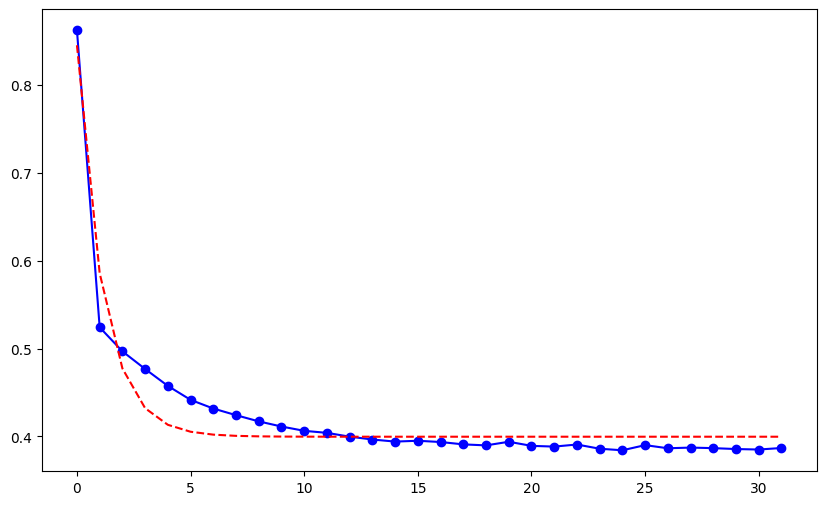

In [6]:
# fit an exponential curve to ratios
from scipy.optimize import curve_fit

def exponential(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.arange(len(ratios))
popt, pcov = curve_fit(exponential, x, ratios)

# Plot the ratios and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(ratios, marker='o', linestyle='-', color='b')
plt.plot(exponential(x, *popt), linestyle='--', color='r')